# Self-Similarity Matrices


## Audio


### Method 1: SSMNet

https://arxiv.org/pdf/2309.02243.pdf


In [47]:
import os
import yaml
from ssmnet.core import SsmNetDeploy

with open(
    os.path.join("ssmnet", "weights_deploy", "config_example.yaml"),
    "r",
    encoding="utf-8",
) as fid:
    config_d = yaml.safe_load(fid)
audio_file = os.path.join("data", "moonlight_sonata.wav")
ssmnet_deploy = SsmNetDeploy(config_d)

In [48]:
# get the audio features patches
feat_3m, time_sec_v = ssmnet_deploy.m_get_features(audio_file)
# process through SSMNet to get the Self-Similarity-Matrix and Novelty-Curve
ssm_net, hat_novelty_np = ssmnet_deploy.m_get_ssm_novelty(feat_3m, True)

### Method 2: Müller Library

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S2_SSM.html


In [49]:
import librosa
import numpy as np

import libfmp.b
import libfmp.c2
import libfmp.c3
import libfmp.c4
import libfmp.c6

audio, sr = librosa.load(audio_file)
audio = np.expand_dims(audio, 0)

# params
down_sampling = 10
norm = "2"
threshold = 0.001
L = 1

In [144]:
from typing import Tuple


def gen_ssm_and_novelty(
    features, L=1, filter_length=41, down_sampling=10
) -> Tuple[np.ndarray, np.ndarray]:
    hop = 1024

    features, _ = libfmp.c3.smooth_downsample_feature_sequence(
        features, sr / hop, filter_length, down_sampling
    )
    features = libfmp.c3.normalize_feature_sequence(features, norm, threshold)

    ssm = np.dot(np.transpose(features), features)
    novelty = libfmp.c4.compute_novelty_ssm(ssm, L, exclude=True)

    return ssm, novelty

#### Chromagram-based SMM


In [51]:
n_fft, hop = 4096, 1024

chromagram = librosa.feature.chroma_stft(
    y=audio, sr=sr, tuning=0, norm=2, hop_length=hop, n_fft=n_fft
)
# x_c, fs_x = libfmp.c3.smooth_downsample_feature_sequence(
#     chromagram.squeeze(), sr / hop, filter_length, down_sampling
# )
# x_c = libfmp.c3.normalize_feature_sequence(x_c, norm="2", threshold=0.001)
# ssm_chroma = np.dot(np.transpose(x_c), x_c)
ssm_c, n_c = gen_ssm_and_novelty(chromagram.squeeze())

#### MFCC-based SMM


In [52]:
n_fft, hop = 2048, 1024
mfcc_range = [4, 15]
mfcc_k = np.arange(mfcc_range[0], mfcc_range[1])  # EXPERIMENT WITH THIS

mfcc = librosa.feature.mfcc(y=audio, sr=sr, hop_length=hop, n_fft=n_fft)
mfcc_upper = mfcc.squeeze()[mfcc_k, :]
# x_m, fs_x = libfmp.c3.smooth_downsample_feature_sequence(
#     mfcc_upper, sr / hop, filt_len=41, down_sampling=10
# )
# x_m = libfmp.c3.normalize_feature_sequence(x_m, norm="2", threshold=0.001)
# ssm_mfcc = np.dot(np.transpose(x_m), x_m)
ssm_m, n_m = gen_ssm_and_novelty(mfcc.squeeze()[mfcc_k, :])

#### Tempogram-based SMM


In [53]:
N, H = 1000, 100
octave_bin = 15

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(
    audio.squeeze(), Fs=sr, N=2048, H=512, gamma=100, M=10, norm=True
)
nov, Fs_nov = libfmp.c6.resample_signal(nov, Fs_in=Fs_nov, Fs_out=100)

x_t, T_coef, F_coef_BPM = libfmp.c6.compute_tempogram_fourier(
    nov, Fs_nov, N=N, H=H, Theta=np.arange(30, 601)
)
output = libfmp.c6.compute_cyclic_tempogram(
    np.abs(x_t), F_coef_BPM, octave_bin=octave_bin
)
x_t = libfmp.c3.normalize_feature_sequence(output[0], norm="2", threshold=0.001)
ssm_tempo = np.dot(np.transpose(x_t), x_t)

### Plot Findings


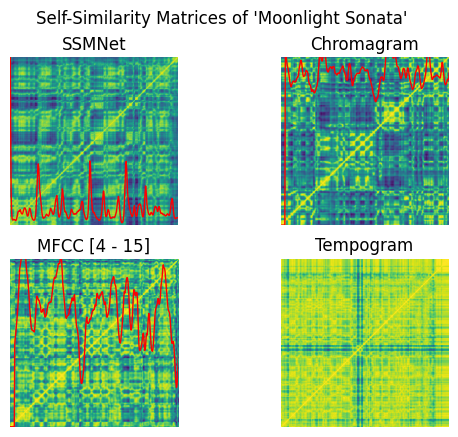

In [54]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

fig.suptitle("Self-Similarity Matrices of 'Moonlight Sonata'")

axs[0, 0].imshow(ssm_net, origin="lower")
axs[0, 0].plot(hat_novelty_np * ssm_net.shape[0], "r", linewidth=1)
axs[0, 0].set_title("SSMNet")
axs[0, 0].axis("off")
axs[0, 1].imshow(ssm_c, origin="lower")
axs[0, 1].plot(n_c, "r", linewidth=1)
axs[0, 1].set_title("Chromagram")
axs[0, 1].axis("off")
axs[1, 0].imshow(ssm_m, origin="lower")
axs[1, 0].plot(n_m, "r", linewidth=1)
axs[1, 0].set_title(f"MFCC [{mfcc_range[0]} - {mfcc_range[1]}]")
axs[1, 0].axis("off")
axs[1, 1].imshow(ssm_tempo, origin="lower")
axs[1, 1].set_title("Tempogram")
axs[1, 1].axis("off")

plt.show()

### Novelty


In [68]:
def boundary_split(array, indices):
    """cgpt-generated"""
    # Check if the indices are valid
    if any(index < 0 or index >= len(array) for index in indices):
        raise ValueError("Invalid index in the list.")

    # Add the start and end indices to the list
    split_indices = [0] + sorted(indices) + [len(array)]

    # Create subarrays using slicing
    subarrays = [
        array[int(split_indices[i]) : int(split_indices[i + 1])]
        for i in range(len(split_indices) - 1)
    ]

    return subarrays

In [78]:
from IPython.display import Audio

hat_boundary_sec_v, hat_boundary_frame_v = ssmnet_deploy.m_get_boundaries(
    hat_novelty_np, time_sec_v
)
sample_boundary = np.asarray(hat_boundary_sec_v) * sr
audio_split = boundary_split(audio.squeeze(), sample_boundary[1:])

Audio(data=audio_split[0], rate=sr, normalize=True)

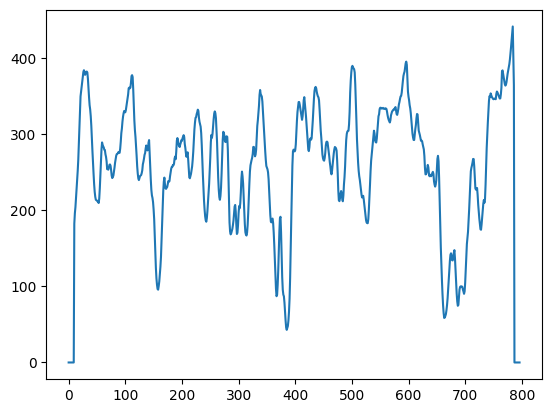

In [55]:
ssm_m, n_m = gen_ssm_and_novelty(mfcc.squeeze()[mfcc_k, :], 1)
ssm_c, n_c = gen_ssm_and_novelty(chromagram.squeeze(), 1)
plt.plot(n_m)
plt.show()

## MIDI


In [79]:
import pretty_midi
from midi_player import MIDIPlayer
from midi_player.stylers import cifka_advanced

midi_file = os.path.join("data", "chet2501.mid")
midi_data = pretty_midi.PrettyMIDI(midi_file)

MIDIPlayer(midi_file, 160, styler=cifka_advanced)

In [146]:
piano_roll = midi_data.get_piano_roll()
pch = midi_data.get_pitch_class_histogram()
# pct = midi_data.get_pitch_class_transition_matrix()

ssm_midi = np.dot(np.transpose(piano_roll), piano_roll)
ssm_midi /= ssm_midi.max()
ssm_midi_smoothed, n_smoothed = gen_ssm_and_novelty(piano_roll)
ssm_midi_smoothed /= ssm_midi_smoothed.max()

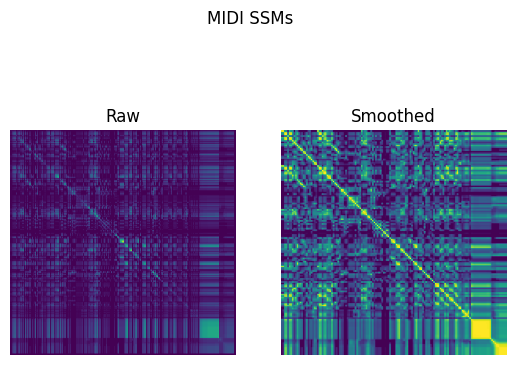

In [147]:
fig, axs = plt.subplots(1, 2)

fig.suptitle("MIDI SSMs")

axs[0].imshow(ssm_midi, cmap="viridis")
axs[0].axis("off")
axs[0].set_title("Raw")
axs[1].imshow(ssm_midi_smoothed, cmap="viridis")
axs[1].axis("off")
axs[1].set_title("Smoothed")

plt.show()

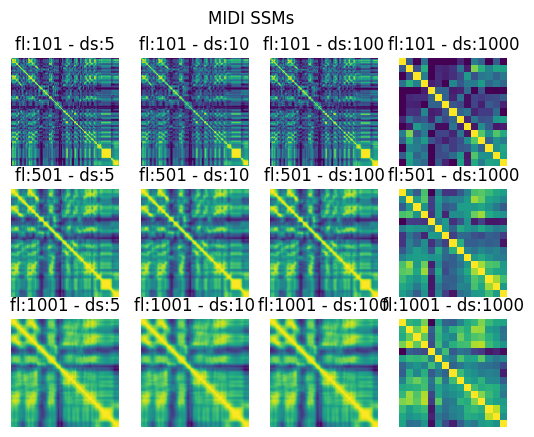

In [155]:
filter_lens = [101, 501, 1001]
downsamples = [5, 10, 100, 1000]
ssms = []
novs = []

for fl in filter_lens:
    ssm_row = []
    nov_row = []
    for ds in downsamples:
        sssm, n_smoothed = gen_ssm_and_novelty(
            piano_roll, filter_length=fl, down_sampling=ds
        )
        sssm /= sssm.max()
        ssm_row.append(sssm)
    ssms.append(ssm_row)

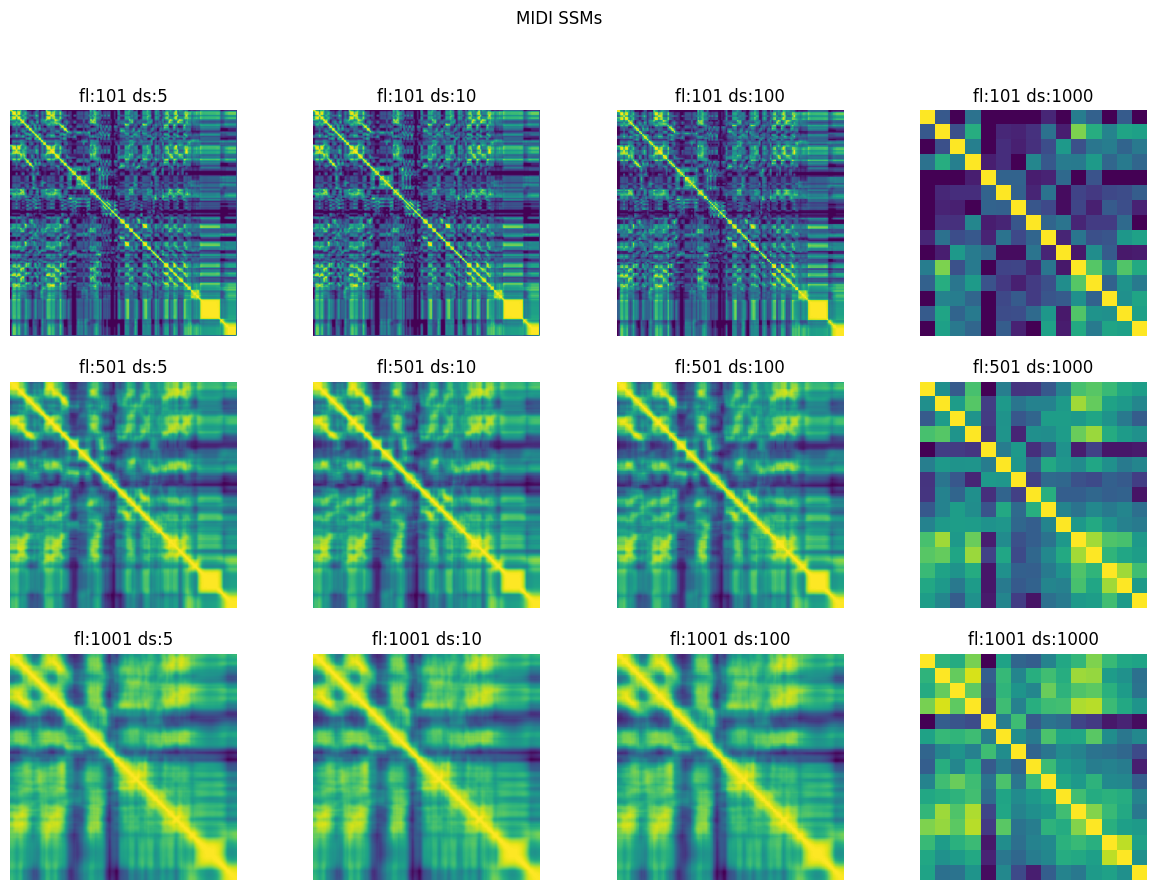

In [158]:
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

fig.suptitle("MIDI SSMs")

for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.imshow(ssms[i][j])
        ax.axis("off")
        ax.set_title(f"fl:{filter_lens[i]} ds:{downsamples[j]}")

plt.show()